In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
def get_probability_df(df):
    """Creates a new dataframe containing probability data
    
    Args:
        df (dataframe): contains experience data from both weapons
        
    Returns:
        probability_df (dataframe): the cumulative number of successful attacks, 
                                    total attacks, probability and weapons
    """
    
    defence_df = df[(df['exp_type'] == "defence") & (df['exp_gained'] != 0)]
    
    successful_attacks = (defence_df['exp_gained'] / 4).astype(int)
    
    rpg_total_attacks = defence_df.loc[defence_df['weapon'] == "Event RPG", 'time_(min)'] * 60 / 1.8
    scim_total_attacks = defence_df.loc[defence_df['weapon'] == "Iron Scimitar", 'time_(min)'] * 60 / 2.4
    total_attacks = rpg_total_attacks.append(scim_total_attacks)
    total_attacks = total_attacks.astype(int)
    
    success_probabilities = successful_attacks / total_attacks
    
    d = { "successful_attacks": successful_attacks,
          "total_attacks": total_attacks,   
          "p": success_probabilities,
          "weapon": defence_df['weapon'] }
    
    probability_df = pd.DataFrame(data = d)
    
    return probability_df
    
def get_interval_hit_data(df, weapon):
    """Gets the number of successful hits for each 10 minute 
    interval 
    
    Args:
        df (dataframe): contains probability data from both weapons
        weapon (string): specifies weapon's hit data will be returned
        
    Returns:
        kde_data (array): the number of successful hits for each 10 minute
                          interval
    """
    
    interval_hit_data = [0]
    interval_hit_data(df.loc[df['weapon'] == weapon, 'successful_attacks'])
    
    interval_hit_data = [interval_hit_data[i] - interval_hit_data[i - 1] for i in range(len(interval_hit_data))]
    interval_hit_data.pop(0)
    interval_hit_data = np.array(interval_hit_data)
    
    return interval_hit_data

def display_interval_data(interval_data, weapon):
    print(weapon, "10-minute interval data:", interval_data)

def get_parameters(df, interval_hit_data, weapon):
    """Gets the final probabilistic parameters 
    
    Args:
        df (dataframe): contains probability data from both weapons
        interval_hit_data (array): 
            contains the number of successful hits in each 10 minutes interval 
            for the given weapon 
        weapon (string): specifies which weapon's parameters will be returned
        
    Returns:
        n (int): total number of attacks 
        p (float): estimate for the probability of landing a successful hit, 
                   rounded to 6 digits
        mean (int) : mean number of successful hits per minute, 
                     rounded to the nearest integer
    """
    
    weapon_df = df[df['weapon'] == weapon]
    
    n = weapon_df['total_attacks'].iloc[-1]
    p = round(weapon_df['p'].iloc[-1], 6)
    mean = np.mean(interval_hit_data) // 10
    
    return n, p, mean

def display_parameters(parameters, weapon):
    print("---", weapon, "---")
    print("n:", parameters[0])
    print("p:", parameters[1])
    print("mean:", parameters[2])

def calculate_pooled_test_power(n1, n2, p1, p2, significance_level, number_of_tails):
    p_bar = (((n1) * (p1)) + ((n2) * (p2))) / (n1 + n2)
    q_bar = 1 - p_bar
    
    tails  = { 1 : stats.norm.ppf(significance_level), 
               2 : stats.norm.ppf(significance_level / 2) }
    
    critical_value = tails[number_of_tails]
    unpooled_standard_error = math.sqrt((p1 * (1 - p1) / n1) + (p2 * (1 - p2) / n2))
    pooled_standard_error = math.sqrt(p_bar * q_bar * ((1 / n1) + (1 / n2)))
    
    power_statistic = (critical_value * unpooled_standard_error + (p1 - p2)) / pooled_standard_error   
    
    power = 1 - round(stats.norm.cdf(power_statistic), 6)
    
    return power

def calculate_pooled_test_statistic(n1, n2, p1, p2):
    p = (((n1) * (p1)) + ((n2) * (p2))) / (n1 + n2)
    sigma = math.sqrt(p * (1 - p) * ((1 / n1) + (1 / n2)))
    
    z = (p1 - p2) / sigma
    rounded_z = round(z, 6)
    
    return rounded_z

def calculate_normal_p_value(test_statistic):
    p_value = stats.norm.cdf(test_statistic) if test_statistic < 0 else stats.norm.sf(test_statistic)
    
    return p_value

def get_z_test_results(n1, n2, p1, p2, significance_level, number_of_tails):
    """Get the power, test statistic and p-value of a 2-sample Z-test that 
    uses the Standard normal distribution
    
    Args:
        n1 (int): the size of the first sample
        n2 (int): the size of the second sample
        p1 (float): the probability of success for the first sample
        p2 (float): the probability of success for the second sample
        significance_level (float): the significance level of the test 
        number_of_tails (int): whether it is a 1 or 2 tailed test
        
    Returns:
        power (float): the probability of rejecting a false null hypothesis
        z_statistic (float): the pooled test statistic 
        p_value (float): the probability of obtaining the observed results
                         assuming that the null hypothesis is true
    """
    
    power = calculate_pooled_test_power(rpg_n, scim_n, rpg_p, scim_p, 0.05, 1)
    z_statistic = calculate_pooled_test_statistic(rpg_n, scim_n, rpg_p, scim_p)
    p_value = calculate_normal_p_value(z_statistic)
    
    return power, z_statistic, p_value

def display_z_test_results(z_test_results):
    print("power =", z_test_results[0])
    print("statistic =", z_test_results[1])
    print("p-value =", z_test_results[2])
    
def calculate_t_test_statistic(interval_data1, interval_data2):
    mu1, mu2 = np.mean(interval_data1), np.mean(interval_data2)
    data1_length, data2_length = len(interval_data1), len(interval_data2)
    pooled_sample_variance = (data1_length * (np.var(interval_data1) + np.var(interval_data2))) / \
                             (data1_length + data2_length - 2)
    
    t = (mu1 - mu2) / math.sqrt(pooled_sample_variance * ((1 / data1_length) + (1 / data2_length)))
    
    return t

def calculate_student_p_value(test_statistic, degrees_freedom):
    if test_statistic < 0:
        p_value = stats.t.cdf(test_statistic, degrees_freedom)
    else: 
        p_value = stats.t.sf(test_statistic, degrees_freedom)
    
    return p_value

# get the test statistic and p-value for the T-Test
def get_t_test_results(interval_data1, interval_data2):
    """Get the test statistic and p-value of a 2-sample T-test that 
    uses a Student distribution with (len(interval_data1) + 
    len(interval_data2) - 2) degrees of freedom
    
    Args:
        interval_data1 (array): 
            the number of successful hits in every 10 minute interval for weapon 1
        interval_data2 (array): 
            the number of successful hits in every 10 minute interval for weapon 2
        
    Returns:
        t_statistic (float): statistic for the T-test
        p_value (float): the probability of obtaining the observed results
                         assuming that the null hypothesis is true
    """
    
    t_statistic = calculate_t_test_statistic(interval_data1, interval_data2)
    degrees_freedom = len(interval_data1) + len(interval_data2) - 2
    p_value = calculate_student_p_value(t_statistic, degrees_freedom)
    
    return t_statistic, p_value
    
def display_t_test_results(t_test_results):
    print("statistic =", t_test_results[0])
    print("p-value =", t_test_results[1])

# graphs a standard normal curve with the option to shade the lower, upper or both tails
def graph_standard_normal(graph_title, significance_level=None, shade=None):
    """Graphs a standard normal curve with the lower, upper, both or no tails shaded
    (default)
    
    Args:
        graph_title: string specifying the graph's title
        significance_level: float representing the area contained within the tail(s)
        shade: string specifying which tail(s) will be shaded, accepts
               "lower", "upper" or  "both"
        
    Returns:
        None
    """
    
    standard_normal_x = np.linspace(stats.norm.ppf(0.001), stats.norm.ppf(0.999), 250)
    standard_normal_y = stats.norm.pdf(standard_normal_x)

    standard_normal_curve = sns.lineplot(standard_normal_x, standard_normal_y)
    standard_normal_curve.set(title = graph_title,
                              ylabel = "Density")
    
    if shade is not None:
        # the area of each tail equal half of the significance level if shading both tails
        d = { "both"  : (1, 1, stats.norm.ppf(significance_level / 2), stats.norm.ppf(1 - significance_level / 2)),
              "lower" : (1, 0, stats.norm.ppf(significance_level), -1),
              "upper" : (0, 1, -1, stats.norm.ppf((1 - significance_level))) }
            
        (shadeLower, shadeUpper, critical_left, critical_right) = d[shade]
        
        if (shadeLower):
            left_tail_x = standard_normal_x[standard_normal_x < critical_left]
            left_tail_y = stats.norm.pdf(left_tail_x)
            plt.fill_between(left_tail_x, left_tail_y, color = "cornflowerblue")
            print("critical value =", critical_left)
        
        if (shadeUpper):
            right_tail_x = standard_normal_x[standard_normal_x > critical_right]
            right_tail_y = stats.norm.pdf(right_tail_x)
            plt.fill_between(right_tail_x, right_tail_y, color = "cornflowerblue")
            print("critical value =", critical_right)
    
    plt.ylim(0, 0.42)
    plt.show()

In [3]:
# load data
combined_df = pd.read_csv("data/combined_data.csv")

In [4]:
# transform data
combined_probability_df = get_probability_df(combined_df)

In [5]:
# write processed data to csv
combined_probability_df.to_csv("data/combined_probability_data.csv", index = False)

In [6]:
# load processed data
combined_probability_df = pd.read_csv("data/combined_probability_data.csv")

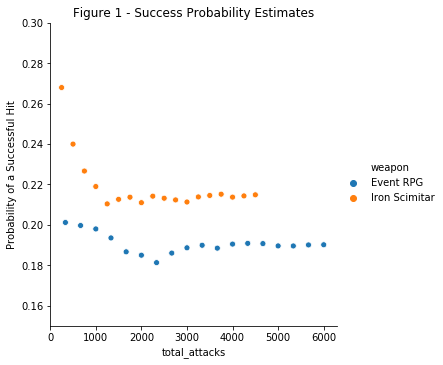

In [7]:
# visualize trend of success probability p as sample size n increases 
successful_hits_scatter = sns.relplot(x = "total_attacks",
                                      y = "p",
                                      hue = "weapon",
                                      data = combined_probability_df)

successful_hits_scatter.set(title = "Figure 1 - Success Probability Estimates",
                            xlabel = "total_attacks",
                            ylabel = "Probability of a Successful Hit")

plt.xlim(5, None)
plt.ylim(0.15, 0.3)

plt.show()

In [8]:
# get the number of successful hits for every 10 minute interval
rpg_interval_hit_data = get_interval_hit_data(combined_probability_df, "Event RPG")
scim_interval_hit_data = get_interval_hit_data(combined_probability_df, "Iron Scimitar")

# probability of successful hits for every individual 10 minute interval
rpg_hit_probability_data = rpg_interval_hit_data / 333
scim_hit_probability_data = scim_interval_hit_data / 250

TypeError: 'list' object is not callable

In [ ]:
# kde for the number and probability of successful hits per 10 minutes
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))

combined_hit_probability_kde = sns.kdeplot(rpg_hit_probability_data, label = "Event RPG", ax = ax1)
combined_hit_probability_kde = sns.kdeplot(scim_hit_probability_data, label = "Iron Scimitar", ax = ax1)

combined_hit_probability_kde.set(title = "Figure 2 - Hit Probability KDE",
                                 xlabel = "Successful Hits Relative to the Total Number of Hits",
                                 ylabel = "Density")

combined_interval_hit_kde = sns.kdeplot(rpg_interval_hit_data, label = "Event RPG", ax = ax2)
combined_interval_hit_kde = sns.kdeplot(scim_interval_hit_data, label = "Iron Scimitar", ax = ax2)

combined_interval_hit_kde.set(title = "Figure 3 - Successful Hit Rate KDE",
                              xlabel = "Successful Hits per 10 Minutes",
                              ylabel = "Density")

plt.show()

Figure 2 suggests that the Iron Scimitar is more accurate than the Event RPG while Figure 3 suggests that training with the Event RPG typically results in more successful hits every 10 minutes. This implies that attack speed results in higher experience rates when compared to attack bonuses.
<br>

Having observed differences between the Event RPG and Iron Scimitar in both the linear regression and the kernel density estimates I now set out to determine whether or not the difference is statistically significant through hypothesis testing.

In [ ]:
# get and display the mean number of successful attacks per minute (rounded), the total number of attacks
# along with success probability estimate (p) for the Event RPG
rpg_parameters = get_parameters(combined_probability_df, 
                                rpg_interval_hit_data, 
                                "Event RPG")

rpg_n, rpg_p = rpg_parameters[0], rpg_parameters[1]

display_parameters(rpg_parameters, "Event RPG")

In [ ]:
scim_parameters = get_parameters(combined_probability_df, 
                                 scim_interval_hit_data,
                                 "Iron Scimitar")

scim_n, scim_p = scim_parameters[0], scim_parameters[1]

display_parameters(scim_parameters, "Iron Scimitar")

Having obtained the parameters for the Event RPG and Iron Scimitar, I proceed to use the p's to construct binomial distributions and formulate hypotheses regarding whether or not attack bonuses affect the probability of a successful hit.
<br>

Letting $R_{b}$ and $S_{b}$ denote the number of successful hits per minute using the Event RPG and Iron Scimitar respectively,



<i> $R_{b}$ ~ binomial ( $a$, $p_{1}$) </i> and <i> $S_{b}$ ~ binomial ( $b$, $p_{2}$) </i> 
where $p_{1}$ = 0.190167 and $p_{2}$ = 0.214889
<br>

Hypotheses:
<br>
$H_{0}$: $p_{1}$ = $p_{2}$
<br>
$H_{1}$: $p_{1}$ ≠ $p_{2}$


<br>
Using a significance level of 0.05, I will reject the null hypothesis if the test statistic falls in the rejection regions (shaded in Figure 4) or, in other words, if there is less than a 5% chance of observing results as extreme or more extreme given that the null hypothesis is true. In terms of pooled test statistic $z_{t}$, the two statements can be expressed as $|z_{t}| > 1.96$ and $2P(Z > |z_{t}|) < 0.05$.


In [ ]:
graph_standard_normal("Figure 4 -Standard Normal Curve with Two Rejection Regions", 0.05, "both")

In [ ]:
z_test_results = get_z_test_results(rpg_n, scim_n, rpg_p, scim_p, 0.05, 1)
display_z_test_results(z_test_results)

The power indicates that the probability of correctly rejecting the null hypothesis is high. It is also important to note that the test statistic and the p-value only reveals that there is a difference between the Event RPG and the Iron Scimitar in terms of accuracy but does not determine which is more accurate given that this was a two-tailed test. Since Figure 2 suggests that the Iron Scimitar had higher accuracy, I formulate a new alternate hypothesis to determine which weapon is more accurate.
<br>

Hypotheses:
<br>
$H_{0}$: $p_{1}$ = $p_{2}$
<br>
$H_{1}$: $p_{1}$ < $p_{2}$
<br>

I will now reject the null hypothesis if $z_{t}$ <u><</u> $-1.64$ or if $P(Z$ <u><</u> $z_{t}) < 0.05$ with the new rejection region being displayed below in Figure 5.

In [ ]:
graph_standard_normal("Figure 5 - Standard Normal Curve with a Lower-Tailed Rejection Region", 0.05, "lower")

After changing the alternate hypothesis, the test statistic also lies in the new rejection region which implies that the Iron Scimitar is indeed more accurate than the Event RPG.

I now formulate hypotheses in terms of μ, which denotes the mean number of successful hits over 10 minutes to test for whether or not there is a difference in terms of experience rates.
<br>

Letting $μ_{1}$ and $μ_{2}$ denote the mean for the Event RPG and Iron Scimitar respectively,
<br>


Hypotheses:
<br>
$H_{0}$: $μ_{1}$ = $μ_{2}$
<br>
$H_{1}$: $μ_{1}$ ≠ $μ_{2}$
<br>

Since the samples (shown below) are small, I proceed to use the two-tailed T-Test from the stats module.

In [ ]:
display_interval_data(rpg_interval_hit_data, "Event RPG")
display_interval_data(scim_interval_hit_data, "Iron Scimitar RPG")

In [ ]:
two_tailed_t_test_results = stats.ttest_ind(rpg_interval_hit_data, scim_interval_hit_data)
display_t_test_results(two_tailed_t_test_results)

The p-value again only reveals that there is a difference between the Event RPG and the Iron Scimitar in terms of the mean number of successful hits since this was a two-tailed test. Following a process similar to that of the Z-Test, I formulate a new alternate hypothesis $H_{1}$ to determine which weapon is more efficient.
<br>

Hypotheses:
<br>
$H_{0}$: $p_{1}$ = $p_{2}$
<br>
$H_{1}$: $p_{1}$ > $p_{2}$

In [ ]:
one_tailed_t_test_results = get_t_test_results(rpg_interval_hit_data, scim_interval_hit_data)
display_t_test_results(one_tailed_t_test_results)

Calculating the test statistic for the T-Test from scratch and using the survival function from the stats module to calculate the p-value I once again reject the null hypothesis in favour of the alternate hypothesis since the probability of observing results similar to or more extreme than the data would be significantly less than 5% assuming that the null hypothesis is true.

<br>
In conclusion, the hypothesis testing reinforces the idea that 1 $-$ The Iron Scimitar is more accurate than the Event RPG and that 2 $-$ The Event RPG is more efficient than the Iron Scimitar in terms of experience per hour.